<a href="https://colab.research.google.com/github/adilsazeez/constellation-graph-reconstruction/blob/main/Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HackIllinois 2026 Pro Challenge

Please direct questions to sherry.long@hackillinois.org.

## [Part 0] Setup

Welcome, new recruit! You've been selected for a critical mission. Our team is counting on you to develop **three new modules** (Look for *#TO DO* comments!). Run the cell below to begin your onboarding.

In [1]:
'''
Provided helper functions.
'''

import cv2
import numpy as np
from scipy.ndimage import label
from scipy.spatial.distance import cdist
from collections import defaultdict
import matplotlib.pyplot as plt
%matplotlib inline


def render_nodes(nodes, base_size=20, size_scale=20, tol=2):
  '''
  Renders nodes as star-shaped markers.
  Groups nearby nodes within tolerance into clusters.
  Plots one marker per cluster with size proportional to number of nodes in cluster.
  '''

  ys, xs = zip(*nodes)
  coords = np.array(list(zip(ys, xs)))
  grid = defaultdict(list)
  gx = np.floor(coords[:,1] / tol).astype(int)
  gy = np.floor(coords[:,0] / tol).astype(int)

  for (yi, xi), gyi, gxi in zip(coords, gy, gx):
      grid[(gyi, gxi)].append((yi, xi))
  xs_plot, ys_plot, sizes = [], [], []

  for (gyi, gxi), cluster in grid.items():
      cluster = np.array(cluster)
      y, x = cluster.mean(axis=0)
      s = base_size + size_scale * len(cluster)

      xs_plot.append(x)
      ys_plot.append(y)
      sizes.append(s)

  plt.scatter(xs_plot, ys_plot, c='white', s=sizes, marker='*')

def render_graph(graph):
  '''
  Renders edges between two nodes in graph.
  '''

  xs, ys = [], []

  for (u, v) in graph.keys():
    y1, x1 = u
    y2, x2 = v
    plt.plot([x1, x2], [y1, y2], c='white', lw=1, alpha=0.7)

def render(graph, nodes):
  render_graph(graph)
  render_nodes(nodes)

def get_skeleton_neighbors(skeleton, center):
  '''
  Return all 8-connected neighboring pixels of center that are part of skeleton.
  '''

  h, w = skeleton.shape
  directions = np.array([
    [-1,-1], [-1,0], [-1,1],
    [ 0,-1],         [ 0,1],
    [ 1,-1], [ 1,0], [ 1,1]
  ])

  neighbors = []
  for dir in directions:
    y, x = center + dir
    if 0 <= y < h and 0 <= x < w and skeleton[y, x]:
      neighbors.append((y, x))

  return neighbors

def get_dist_to_edge(path, edge):
  '''
  Calculates the perpendicular distances from each pixel in a path to an edge defined by two nodes.

  Returns:
    dists: list
  '''
  u, v = edge
  y1, x1 = u
  y2, x2 = v

  A = y2 - y1
  B = x1 - x2
  C = x2*y1 - x1*y2

  dists = []

  for y, x in path:
    d = np.abs(A*x + B*y + C) / np.sqrt(A**2 + B**2)
    dists.append(d)

  return dists

## [Part 1] Preparation

We've detected a new celestial formation, but we need to map its position. Your task is to reconstruct the constellation from the uncharted profile. Run the cell below to visualize your target.

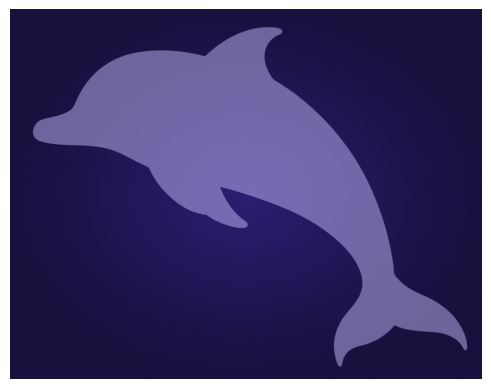

In [2]:
import urllib.request

file_id = '16nz6i-ScM7_3s2KqHKWQGmwLr1Tx0zbH'  # TO DO: change to your file ID
if not file_id:
    raise NotImplementedError("File ID is empty.")

url = f"https://drive.google.com/uc?export=download&id={file_id}"

response = urllib.request.urlopen(url)
image_data = np.asarray(bytearray(response.read()), dtype=np.uint8)
base = cv2.imdecode(image_data, cv2.IMREAD_COLOR)
base = cv2.cvtColor(base, cv2.COLOR_BGR2RGB)

plt.imshow(base)
plt.axis('off')
plt.show()

Our automated systems have processed the input for you. The scan was converted to grayscale, then Otsu's algorithm was applied to separate dark and light regions, generating a binary mask of the target.

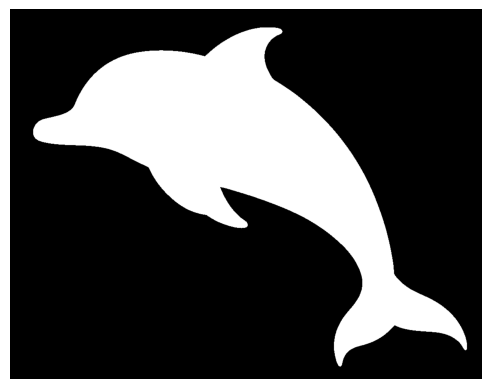

In [3]:
from skimage.filters import threshold_otsu

'''
Otsu threshold t: splits pixels into dark vs light groups automatically.
'''

grayscale_base = cv2.cvtColor(base, cv2.COLOR_BGR2GRAY)
t = threshold_otsu(grayscale_base)
binary_mask = grayscale_base >= t # filters pixels lighter than background

plt.imshow(binary_mask, cmap='gray')
plt.axis('off')
plt.show()

From the binary mask, we extracted the profile's skeleton, mapping the path that your constellation will follow.

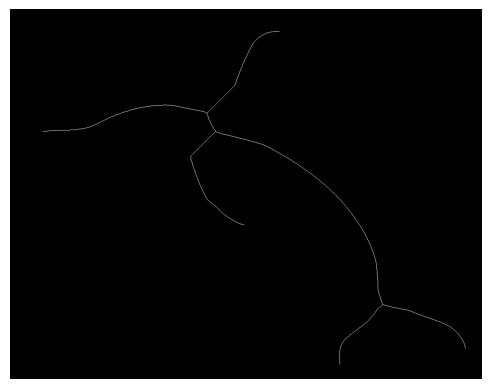

In [4]:
from skimage.morphology import skeletonize

'''
skeleton (bool): 1 for pixels on skeleton.
'''

skeleton = skeletonize(binary_mask)

plt.imshow(skeleton, cmap='gray')
plt.axis('off')
plt.show()

Next, we can pinpoint the stars by identifying the critical points in the skeleton, which include endpoints and junctions.

In [5]:
'''
For every pixel on the skeleton, count how many of its 8 neighboring pixels are also skeleton pixels.

Degree 1 → Endpoint
Degree 2 → Point on simple path
Degree ≥ 3 → Junction or branching point
'''

kernel = np.array([
         [1,1,1],
         [1,0,1],
         [1,1,1]])

degree_map = cv2.filter2D(skeleton.astype(np.uint8), -1, kernel, borderType=cv2.BORDER_CONSTANT) # convolves the skeleton with the kernel

Our `render_nodes` module allows us to visualize all the stars we've detected.

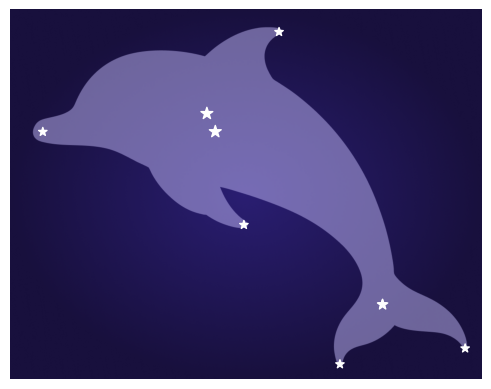

In [6]:
'''
Collect the nodes of the skeleton graph by finding every pixel where degree != 2 (endpoints and junctions).
'''

node_mask = (skeleton > 0) & (degree_map != 2)
ys, xs = np.nonzero(node_mask)
nodes = set(zip(ys, xs))

plt.imshow(base)
render_nodes(nodes)

plt.axis('off')
plt.show()

## [Part 2] Build Constellation

Now that we've located the stars, we need your help to reconstruct the constellation. Our team needs a new `skeleton_to_graph` module. Start with the `trace_edges` helper module.

**`trace_edges`**

**Purpose:** Starting from a given node, traverse the skeleton in every direction to find all paths leading to adjacent nodes.

**Parameters:**

`start`: A tuple representing the starting node coordinates.

`node_set`: The set of all nodes in the skeleton as (y, x) tuples.


**Return Value:**

`edges`: A list of tuples, where each tuple contains:

- `end_node`: The coordinates of an adjacent node reached from the start node.

- `path`: A list of coordinates representing the skeleton points between the start and end nodes, exclusive.

**Implementation:**

1. Find branches: Identify all skeleton points directly adjacent to your start node. Each of these represents a potential path to trace.
2. Trace each branch: For each adjacent point,
    - Keep track of the previous point to avoid backtracking.
    - Build a path by keeping track of the points you trace.
    - Move forward along the skeleton by finding the next unvisited neighbor.
3. Stopping condition: Stop tracing when you reach a point that exists in `node_set`. This is your end node.

    **Key insight:** While traversing the path, each point should have exactly one neighbor you haven't visited yet (the previous point being the one you just came from).

**Provided Helper Module:**

`get_skeleton_neighbors(skeleton, center)` returns a list of neighboring skeleton pixels around center, represented as (y, x) coordinates.

In [7]:
def trace_edges(start, node_set): # TO DO
  '''
  Trace all paths from start node to another adjacent node.
  Path is a list of all skeleton points between two nodes, not including start and end nodes.

  Returns:
    edges: list [(end_node, [path])]
  '''

  edges = []

  # Get initial branches from the starting node
  initial_neighbors = get_skeleton_neighbors(skeleton, start)

  for neighbor in initial_neighbors:
      # If the immediate neighbor is already a node, it's a zero-length path edge
      if neighbor in node_set:
          edges.append((neighbor, []))
          continue

      # Initialize tracing state
      path = [neighbor]
      prev_point = start
      current_point = neighbor

      # Traverse the skeleton
      while True:
          # Get neighbors of the current point
          neighbors = get_skeleton_neighbors(skeleton, current_point)

          # Filter out the point we just came from
          valid_neighbors = [n for n in neighbors if n != prev_point]

          if not valid_neighbors:
              # Dead end (shouldn't happen in a proper skeleton graph between nodes)
              break

          # There should be exactly one valid neighbor to continue the path
          next_point = valid_neighbors[0]

          # Check if we hit a known node
          if next_point in node_set:
              edges.append((next_point, path))
              break

          # Continue traversing
          path.append(next_point)
          prev_point = current_point
          current_point = next_point

  return edges

**`skeleton_to_graph`**

**Purpose:** Convert the skeleton into a graph representation by mapping its nodes and edges.

**Parameters:**

`nodes`: The set of all nodes in the skeleton as (y, x) tuples.

**Return Value:**

`graph`: A dictionary mapping edges to paths.
- *Key:* A tuple (start_node, end_node) representing an edge.
- *Value:* A list of coordinates representing the skeleton points between the start and end nodes, exclusive.

`graph_nodes`: The set of all nodes in the final graph.

**Implementation:**

1. Process each node: Iterate through the given nodes and use `trace_edges` to find connections from each one.

2. Build the graph dictionary: For each edge discovered,
    - Create a consistent edge representation (Hint: the edge from A→B should be stored the same as B→A).
    - Store the path associated with that edge.
    - Track which nodes are part of the graph.

    **Check path direction:** For each edge (A, B), the path must be ordered in the forward direction from A to B, not B to A.

    **Avoid duplication:** Since each edge connects two nodes, you'll discover each edge twice (once from each end). Make sure your edge representation handles this properly.

In [8]:
def skeleton_to_graph(nodes): # TO DO
  '''
  Convert pixel skeleton into edge paths between nodes.
  Path is a list of all skeleton points between two nodes, not including start and end nodes.

  Returns:
    graph: dict {(start_node, end_node): [path]}
    graph_nodes: set
  '''
  graph = {}
  graph_nodes = set(nodes)

  for node in nodes:
      # Trace edges starting from this node
      discovered_edges = trace_edges(node, nodes)

      for end_node, path in discovered_edges:
          # Create a consistent edge key (sort tuples to avoid duplicates like (A,B) vs (B,A))
          edge_key = tuple(sorted((node, end_node)))

          # Avoid processing the same edge twice
          if edge_key not in graph:
              # If the sorted key matches the current direction (node -> end_node), use path as is.
              # If it swapped (end_node -> node), we must reverse the path to maintain direction A->B.
              if edge_key == (node, end_node):
                  graph[edge_key] = path
              else:
                  graph[edge_key] = path[::-1]

  return graph, graph_nodes

Our `render` module can help you check your output below.

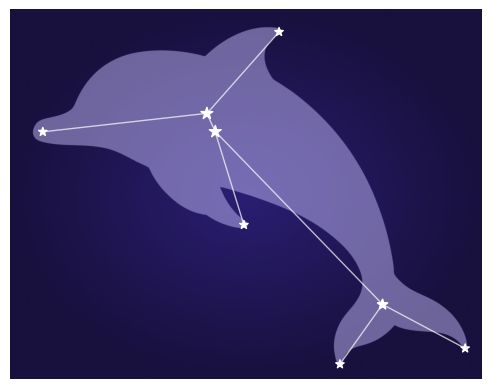

In [9]:
graph, graph_nodes = skeleton_to_graph(nodes)

plt.imshow(base)
render(graph, graph_nodes)

plt.axis('off')
plt.show()

## [Part 3] Refine Constellation

Good work! The constellation looks solid, but we're still not quite seeing the full picture. Our team will need a new `split_edge` module to further refine the structure.

**`split_edge`**

**Purpose:** Refine the graph by inserting new nodes where the skeleton path deviates significantly from the edge.

**Parameters:**

`edge`: A tuple (u, v) representing the two nodes defining an edge.

`path`: A list of coordinates representing the skeleton points between the start and end nodes, exclusive.

`nodes`: The set of all nodes in the original graph.

`tol`: The maximum allowed distance to an edge (default: 25 pixels).

**Return Value:** None, modifies nodes set in-place.

**Implementation:**

1. Base case: Use `get_dist_to_edge` to calculate how far each path point deviates from the edge. If the maximum deviation is within tolerance, no split is needed.

2. Recursive case: If the path deviates above tolerance,

    - Find the point that deviates the farthest from the edge.
    - This point becomes a new node. Add it to the new nodes set.
    - Now you have two new edges: one from the original start to the new node, and one from the new node to the original end.

3. Recurse on each new segment: Apply the same splitting logic to the new edges defined by (start_node, new_node) and (new_node, end_node).

    **Be careful with list slicing:** Make sure the paths don't include the endpoints.

**Provided Helper Module:**

`get_dist_to_edge(path, edge)` returns a list of perpendicular distances from each point in the path to its closest point on the edge.

In [10]:
def split_edge(edge, path, nodes, tol=25): # TO DO
  '''
  Recursively splits edge and adds new node if path deviates too far from edge.
  '''
  import numpy as np # Ensure numpy is available for argmax if needed, or use python list methods

  # Calculate distances from every point in the path to the straight line edge
  dists = get_dist_to_edge(path, edge)

  # Base case: if path is empty or max deviation is within tolerance, stop.
  if not dists or max(dists) <= tol:
      return

  # Find the point with maximum deviation
  max_dist_index = np.argmax(dists)
  new_node = path[max_dist_index]

  # Add the new node to the set (in-place modification)
  nodes.add(new_node)

  # Split the path into two segments, excluding the new node itself
  # Path from Start -> New Node
  path_left = path[:max_dist_index]
  # Path from New Node -> End
  path_right = path[max_dist_index+1:]

  # Recursively split the new segments
  # The original edge is (u, v). New edges are (u, new_node) and (new_node, v).
  split_edge((edge[0], new_node), path_left, nodes, tol)
  split_edge((new_node, edge[1]), path_right, nodes, tol)

Our `render` module can help you check your final output below.

This is a preview. Download your output 'solution.png' from the Files tab on the left side navigation bar.


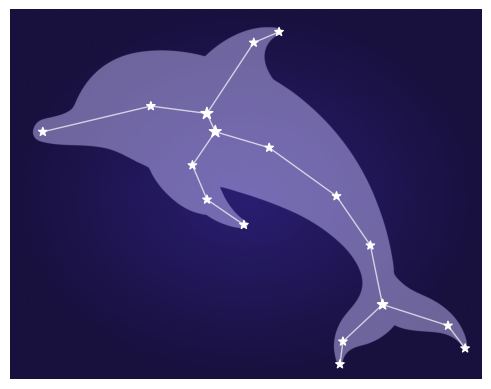

In [11]:
refined_nodes = set(nodes)
for edge, path in graph.items():
  split_edge(edge, path, refined_nodes)

refined_graph, refined_graph_nodes = skeleton_to_graph(refined_nodes)

plt.imshow(base)
render(refined_graph, refined_graph_nodes)

print("This is a preview. Download your output 'solution.png' from the Files tab on the left side navigation bar.")
plt.axis('off')
plt.savefig('solution.png', bbox_inches='tight', pad_inches=0)
plt.show()

Thanks for your help and congrats on completing your mission! You can download your final output from the Files tab on the left side navigation bar.